# Two Qubit CNOT Gate with Piccolo.jl

In [34]:
using LinearAlgebra
using Piccolo

## System Hamiltonian

The Hamiltonian for this two qubit system example is given by

$$
H(u(t)) = g \hat a^\dagger \hat a \hat b^\dagger \hat b + a_1(t) (\hat a + \hat a^\dagger) + i a_2(t) (\hat a - \hat a^\dagger) + a_3(t) (\hat b + \hat b^\dagger) + i a_4(t)(\hat b - \hat b^\dagger) 
$$

where $\hat a$ and $\hat b$ are the annihilation operators for the first and second qubit respectively, $g$ is the coupling strength, and $u_i(t)$ are the control functions.


In [35]:
function TwoQubitSystem(levels::Int)

    g_coupling = 0.1 # GHz (linear units)

    # annihilation operator for qubit 1 
    â = QuantumCollocation.lift(annihilate(levels), 1, 2)

    # annihilation operator for qubit 2
    b̂ = QuantumCollocation.lift(annihilate(levels), 2, 2);

    # drift Hamiltonian
    H_drift = 2π * g_coupling * â' * â * b̂' * b̂

    # drive Hamiltonians
    H_drives = [
        2π * (â + â'),
        2π * 1.0im * (â - â'),
        2π * (b̂ + b̂'),
        2π * 1.0im * (b̂ - b̂') 
    ]

    return QuantumSystem(H_drift, H_drives);
end;

In [36]:
levels_per_qubit = 2
system = TwoQubitSystem(levels_per_qubit);

## CNOT Unitary Gate

The goal gate that we will be optimizing for is the CNOT gate defined as

$$
U_{CNOT} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$


In [37]:
U_goal = [
    1 0 0 0;
    0 1 0 0;
    0 0 0 1;
    0 0 1 0
]; 

## Time Discretization Parameters

Here we will define the temporal discretization parameters for the control functions. We will use a total time of $T = 15$ and a time step of $\Delta t = 0.1$.

In [38]:
T = 15.0 # ns
N = 100
Δt = T / N;

## Pulse Constraints

Here we define bounds on the control as well as a constraint on the second derivative of the control that enforces smoothness of the pulse.

In [39]:
a_bound = 0.0175 # GHz
dda_bound = 0.2; # bound on second derivative of control, to ensure smoothness

## Defining The Problem

Here we define the problem using the `UnitarySmoothPulseProblem` which handles setting up a smoothness constrained pulse optimization problem for a unitary gate.

In [40]:
# setting maximum number of iterations 
max_iter = 100 

# TODO: change const violation tolerance
prob = UnitarySmoothPulseProblem(
    system,
    U_goal,
    N,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    max_iter=max_iter,
)

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(46) … MOI.VariableIndex(4411) MOI.VariableIndex(4456); MOI.VariableIndex(2) MOI.VariableIndex(47) … MOI.VariableIndex(4412) MOI.VariableIndex(4457); … ; MOI.VariableIndex(44) MOI.VariableIndex(89) … MOI.VariableIndex(4454) MOI.VariableIndex(4499); MOI.VariableIndex(45) MOI.VariableIndex(90) … MOI.VariableIndex(4455) MOI.VariableIndex(4500)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.6283185307179586], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 6.283185307179586 0.0; 0.0 0.0 0.0 6.283185307179586; 6.283185307179586 0.0 0.0 0.0; 0.0 6.283185307179586 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 6.283185307179586 0.0 0.0; 6.283185307179586 0.0 0.0 0.0; 0.0 0.0 0.0 6.283185307179586; 0.0 0.0 6.283185307179586 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 0.0 

Here we plot the initial guess for the unitary and controls, which are stored as `Symbol`s, `:Ũ⃗` and `:a`, respectively. Note that the initial guess for the unitary is not random, it is in fact the geodesic path between the identity and the target unitary. This is not required for the optimizer to converge, but it can help speed up convergence.

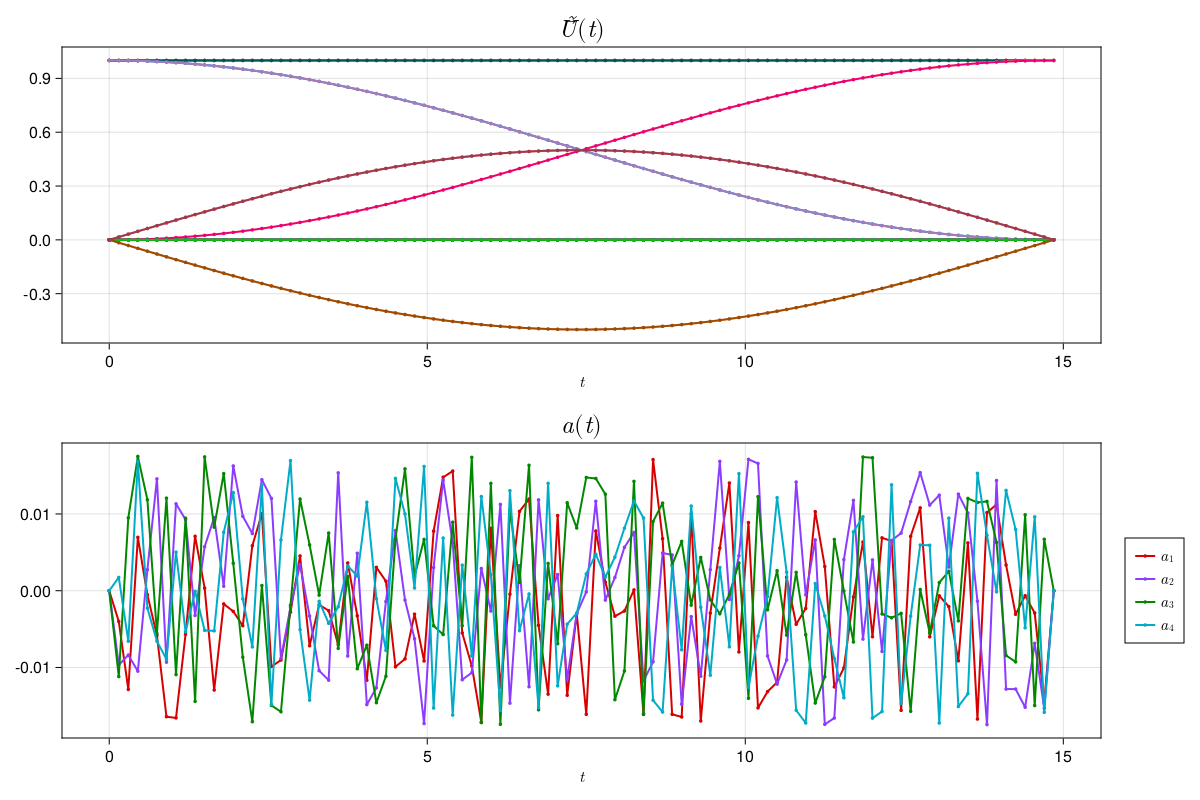

In [41]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

In [42]:
traj = prob.trajectory
traj.names

(:Ũ⃗, :a, :da, :dda, :Δt)

In [44]:
traj.T * traj.dim

4500

Here we call the `solve!` method on the problem, which uses the interior point nonlinear solver IPOPT to optimize over the states and controls of the problem.

In [46]:
QuantumCollocation.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34296

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.8387756e-04 1.10e-01 2.45e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  5.0553110e+01 3.55e-02 2.50e+01  -1.7 1.76e+00    -  1.00e+00 1.00e+00h  1


   2  2.1671743e+01 3.35e-02 2.61e+01  -1.7 3.46e+01    -  4.13e-02 4.28e-02f  1


   3  4.8072063e+00 3.30e-02 2.75e+01  -1.7 4.01e+00    -  4.09e-02 1.41e-01f  1


   4  1.5524998e+00 3.02e-02 2.46e+01  -1.7 2.12e+00   0.0 8.53e-02 8.65e-02f  1


   5  2.9673598e+01 3.35e-02 2.71e+01  -1.7 7.30e+00    -  9.35e-03 7.93e-02h  1


   6  2.0278504e+01 3.39e-02 2.68e+01  -1.7 2.13e+01  -0.5 7.88e-03 1.04e-02f  1


   7  2.0007168e+01 3.36e-02 3.60e+01  -1.7 1.09e+00  -0.1 2.23e-01 9.76e-03f  1


   8  1.2510353e+01 3.12e-02 3.25e+01  -1.7 1.54e+00  -0.5 7.24e-02 8.69e-02f  1


   9  1.4947949e+01 2.77e-02 3.12e+01  -1.7 1.97e+00  -1.0 8.28e-02 2.09e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0426464e+00 2.52e-02 2.64e+01  -1.7 2.51e+00    -  1.38e-01 1.26e-01f  1


  11  5.7293227e+00 2.21e-02 2.97e+01  -1.7 1.48e+00  -0.6 4.45e-02 1.55e-01h  1


  12  1.2846101e+01 2.14e-02 2.33e+01  -1.7 3.53e+00    -  3.89e-02 1.05e-01h  2


  13  2.9750183e+00 2.07e-02 2.68e+01  -1.7 4.64e+00  -1.1 1.68e-01 6.26e-02f  2


  14  7.7156032e+00 1.83e-02 3.31e+01  -1.7 1.88e+00  -0.6 3.56e-01 1.93e-01h  1


  15  4.5658350e+00 1.70e-02 2.27e+01  -1.7 3.35e+00    -  1.07e-01 7.91e-02f  1


  16  1.2332221e+00 9.28e-03 1.85e+01  -1.7 8.82e-01  -0.2 2.99e-02 4.54e-01f  1


  17  6.5134439e-01 9.16e-03 3.98e+01  -1.7 5.81e+00    -  4.20e-02 1.58e-02f  2


  18  1.1253330e+01 7.10e-03 2.21e+01  -1.7 7.39e-01  -0.7 2.00e-01 3.03e-01h  1


  19  7.9651643e+00 6.09e-03 1.74e+01  -1.7 5.97e-01  -0.3 5.87e-02 2.15e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.7770042e+00 7.11e-03 4.06e+01  -1.7 1.21e+00  -0.7 2.02e-01 4.49e-01F  1


  21  7.8695275e+00 5.64e-03 4.23e+01  -1.7 3.35e-01  -0.3 3.50e-01 8.28e-01h  1


  22  7.4474142e+00 3.80e-03 2.92e+01  -1.7 1.54e-01   1.0 1.00e+00 3.12e-01f  1


  23  6.0817718e+00 1.28e-03 1.10e+01  -1.7 9.55e-02   0.5 7.75e-01 1.00e+00f  1


  24  4.0113259e+00 2.83e-03 9.10e+00  -1.7 9.97e-01    -  1.66e-01 1.84e-01f  1


  25  1.0155486e-01 3.36e-03 4.11e+00  -1.7 3.52e-01    -  4.67e-01 6.74e-01f  1


  26  7.5916086e-01 1.44e-03 6.13e-01  -1.7 1.36e-01    -  1.00e+00 8.62e-01h  1


  27  1.1668723e+00 3.64e-04 2.85e-02  -1.7 5.65e-02    -  1.00e+00 1.00e+00f  1


  28  2.9630273e-01 3.52e-04 6.62e-01  -2.5 6.64e-02    -  8.27e-01 1.00e+00f  1


  29  3.2321541e-01 1.78e-05 1.91e-02  -2.5 1.63e-02   0.1 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.8150313e-02 1.40e-04 3.64e-01  -3.8 3.52e-02  -0.4 8.28e-01 1.00e+00f  1


  31  2.3776153e-02 1.38e-04 5.00e+01  -3.8 3.50e-02  -0.9 1.00e+00 1.00e+00h  1


  32  5.3896983e-02 2.98e-05 5.00e+01  -3.8 1.48e-02  -0.5 6.81e-01 1.00e+00h  1


  33  4.7656606e-02 2.25e-05 3.76e+01  -3.8 2.00e-02   0.9 1.00e+00 2.48e-01h  1


  34  4.8176138e-02 1.97e-05 3.29e+01  -3.8 1.97e-03   1.3 1.00e+00 1.25e-01f  4


  35  4.6377444e-02 7.95e-07 2.88e-01  -3.8 3.10e-03   0.8 1.00e+00 1.00e+00h  1


  36  3.4951687e-02 2.54e-06 1.09e-02  -3.8 4.96e-03   0.3 1.00e+00 1.00e+00h  1


  37  1.8333104e-02 8.19e-06 5.79e-03  -3.8 7.79e-03  -0.1 1.00e+00 1.00e+00h  1


  38  7.2589603e-03 7.72e-06 3.15e-03  -3.8 1.29e-02  -0.6 1.00e+00 1.00e+00h  1


  39  5.1902401e-03 8.79e-06 1.68e-03  -3.8 2.07e-02  -1.1 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.0790221e-03 6.56e-06 5.68e-04  -3.8 2.08e-02  -1.6 1.00e+00 1.00e+00H  1


  41  3.7431149e-03 2.27e-06 3.33e-04  -4.0 4.24e-03  -1.1 1.00e+00 1.00e+00h  1


  42  2.8946382e-03 5.17e-05 1.23e-03  -4.0 2.00e-02  -1.6 1.00e+00 1.00e+00h  1


  43  2.8208574e-03 4.24e-06 4.01e-04  -4.0 5.79e-03  -1.2 1.00e+00 1.00e+00h  1


  44  2.9635915e-03 9.13e-05 3.24e-03  -4.0 2.01e-02  -1.7 1.00e+00 1.00e+00H  1


  45  2.7387821e-03 3.12e-06 5.00e+01  -4.0 7.38e-03  -1.2 1.00e+00 1.00e+00h  1


  46  8.4008859e-03 1.52e-06 5.00e+01  -4.0 9.42e-03  -1.7 1.00e+00 1.00e+00H  1


  47  7.7039202e-03 1.07e-07 1.81e-01  -4.0 1.05e-03   1.4 1.00e+00 1.00e+00h  1


  48  7.0395861e-03 6.69e-08 8.80e-03  -4.0 1.02e-03   0.9 1.00e+00 1.00e+00h  1


  49  6.0204279e-03 1.03e-07 3.45e-03  -4.0 1.20e-03   0.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.5847815e-03 4.32e-07 2.04e-03  -4.0 2.12e-03  -0.0 1.00e+00 1.00e+00h  1


  51  3.3297163e-03 7.02e-07 9.47e-04  -4.0 2.96e-03  -0.5 1.00e+00 1.00e+00h  1


  52  2.6918765e-03 1.14e-06 3.70e-04  -4.0 3.47e-03  -1.0 1.00e+00 1.00e+00h  1


  53  2.6991248e-03 8.66e-06 5.00e+01  -4.0 9.22e-03  -1.4 1.00e+00 1.00e+00h  1


  54  3.2936345e-03 1.68e-05 2.50e+01  -4.0 2.00e-02  -1.9 1.00e+00 5.00e-01h  2


  55  2.9862417e-03 8.98e-07 2.84e-01  -4.0 3.48e-03   0.3 1.00e+00 1.00e+00h  1


  56  3.0515209e-03 3.09e-07 1.13e-03  -4.0 1.67e-03  -0.2 1.00e+00 1.00e+00h  1


  57  2.7429919e-03 2.49e-07 4.56e-04  -4.0 2.03e-03  -0.6 1.00e+00 1.00e+00h  1


  58  2.2484932e-03 1.60e-06 3.29e-04  -4.0 4.09e-03  -1.1 1.00e+00 1.00e+00h  1


  59  2.1241766e-03 7.24e-06 7.46e-04  -4.0 1.14e-02  -1.6 1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.3659117e-03 8.42e-06 4.99e+01  -4.0 2.83e-02  -2.1 1.00e+00 2.50e-01h  3


  61  2.1218087e-03 1.11e-04 1.25e+01  -4.0 1.29e-01  -2.6 8.39e-01 2.50e-01h  3


  62  2.0733474e-03 4.25e-07 5.57e-02  -4.0 3.64e-03  -0.3 1.00e+00 1.00e+00h  1


  63  2.2614109e-03 2.45e-07 2.70e-04  -4.0 1.71e-03  -0.8 1.00e+00 1.00e+00h  1


  64  1.7544873e-03 2.07e-06 4.99e+01  -4.0 4.56e-03  -1.3 1.00e+00 1.00e+00h  1


  65  5.6185264e-03 9.43e-08 4.99e+01  -4.0 6.65e-03  -1.8 1.00e+00 1.00e+00H  1


  66  5.1663705e-03 8.11e-08 1.60e-01  -4.0 9.10e-04   1.4 1.00e+00 1.00e+00h  1


  67  4.7552430e-03 4.87e-08 6.69e-03  -4.0 8.38e-04   0.9 1.00e+00 1.00e+00h  1


  68  4.1179105e-03 7.40e-08 2.56e-03  -4.0 9.62e-04   0.4 1.00e+00 1.00e+00h  1


  69  3.2196177e-03 2.80e-07 1.63e-03  -4.0 1.84e-03  -0.1 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.4489569e-03 4.90e-07 7.49e-04  -4.0 2.53e-03  -0.5 1.00e+00 1.00e+00h  1


  71  2.0463160e-03 7.22e-07 2.93e-04  -4.0 2.98e-03  -1.0 1.00e+00 1.00e+00h  1


  72  2.0399265e-03 1.03e-06 3.47e-04  -4.0 6.66e-03  -1.5 1.00e+00 1.00e+00H  1


  73  1.7444106e-03 1.31e-06 4.99e+01  -4.0 1.76e-02  -2.0 1.00e+00 2.50e-01h  3


  74  2.5841086e-03 1.59e-05 2.49e+01  -4.0 2.40e-02  -2.4 1.00e+00 5.00e-01h  2


  75  1.6899182e-03 7.95e-06 1.25e+01  -4.0 6.85e-03  -0.2 1.00e+00 5.00e-01h  2


  76  1.8531871e-03 1.41e-06 4.99e+01  -4.0 4.46e-03  -0.7 1.00e+00 1.00e+00h  1


  77  5.9883885e-03 4.46e-09 4.99e+01  -4.0 5.97e-03  -1.2 1.00e+00 1.00e+00H  1


  78  3.4088599e-03 1.67e-06 7.18e-01  -4.0 4.09e-03   1.1 1.00e+00 1.00e+00f  1


  79  3.9019940e-03 1.03e-07 5.16e-03  -4.0 1.31e-03   0.6 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.2461564e-03 5.03e-10 1.84e-03  -4.0 1.41e-03   0.1 1.00e+00 1.00e+00H  1


  81  2.4236310e-03 3.59e-07 9.74e-04  -4.0 2.23e-03  -0.4 1.00e+00 1.00e+00f  1


  82  2.0361143e-03 4.74e-07 3.67e-04  -4.0 2.52e-03  -0.8 1.00e+00 1.00e+00h  1


  83  1.6858286e-03 1.46e-06 4.99e+01  -4.0 3.79e-03  -1.3 1.00e+00 1.00e+00h  1


  84  4.7382410e-03 2.88e-08 4.99e+01  -4.0 5.99e-03  -1.8 1.00e+00 1.00e+00H  1


  85  4.3393828e-03 8.11e-08 1.62e-01  -4.0 9.06e-04   1.3 1.00e+00 1.00e+00h  1


  86  4.0131489e-03 4.03e-08 5.63e-03  -4.0 7.63e-04   0.9 1.00e+00 1.00e+00h  1


  87  3.4922159e-03 6.77e-08 2.21e-03  -4.0 8.98e-04   0.4 1.00e+00 1.00e+00h  1


  88  2.7625584e-03 2.37e-07 1.42e-03  -4.0 1.74e-03  -0.1 1.00e+00 1.00e+00h  1


  89  2.1614457e-03 3.94e-07 6.31e-04  -4.0 2.31e-03  -0.6 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.8544234e-03 5.45e-07 2.42e-04  -4.0 2.66e-03  -1.0 1.00e+00 1.00e+00h  1


  91  1.9004512e-03 6.65e-07 2.89e-04  -4.0 5.26e-03  -1.5 1.00e+00 1.00e+00H  1


  92  1.6574081e-03 8.47e-07 4.98e+01  -4.0 1.33e-02  -2.0 1.00e+00 2.50e-01h  3


  93  1.9163978e-03 1.80e-06 1.25e+01  -4.0 1.41e-02  -2.5 1.00e+00 2.50e-01h  3


  94  1.9503292e-03 7.38e-08 4.16e-02  -4.0 1.17e-03  -0.2 1.00e+00 1.00e+00h  1


  95  1.9191982e-03 8.08e-08 2.16e-04  -4.0 1.13e-03  -0.7 1.00e+00 1.00e+00h  1


  96  1.7001711e-03 4.65e-07 1.47e-04  -4.0 2.25e-03  -1.2 1.00e+00 1.00e+00h  1


  97  1.7921724e-03 1.28e-06 4.03e-04  -4.0 6.09e-03  -1.7 1.00e+00 1.00e+00H  1


  98  1.8129497e-03 1.21e-06 4.98e+01  -4.0 1.43e-02  -2.1 1.00e+00 2.50e-01h  3


  99  2.1245783e-03 8.36e-06 2.49e+01  -4.0 1.79e-02  -2.6 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1738823e-03 2.75e-07 1.53e-01  -4.0 1.75e-03   0.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   2.1738823487099284e-03    2.1738823487099284e-03
Dual infeasibility......:   1.5333136801831079e-01    1.5333136801831079e-01
Constraint violation....:   2.7484646536457547e-07    2.7484646536457547e-07
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0002949105441850e-04    1.0002949105441850e-04
Overall NLP error.......:   1.5333136801831079e-01    1.5333136801831079e-01


Number of objective function evaluations             = 154
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 154
Number of ine

Let's now calculate the fidelity of the optimized unitary with the target unitary, via rollout with the full matrix exponential, this is achieved via the `unitary_fidelity` method.

In [47]:
fid = unitary_fidelity(prob.trajectory, system)
println("Fidelity: $fid")

Fidelity: 0.9999923457384685


In [48]:
unitary_fidelity(prob.trajectory[end].Ũ⃗, prob.trajectory.goal.Ũ⃗)

0.9999937124890472

And now let's plot the final solution for the unitary and controls.

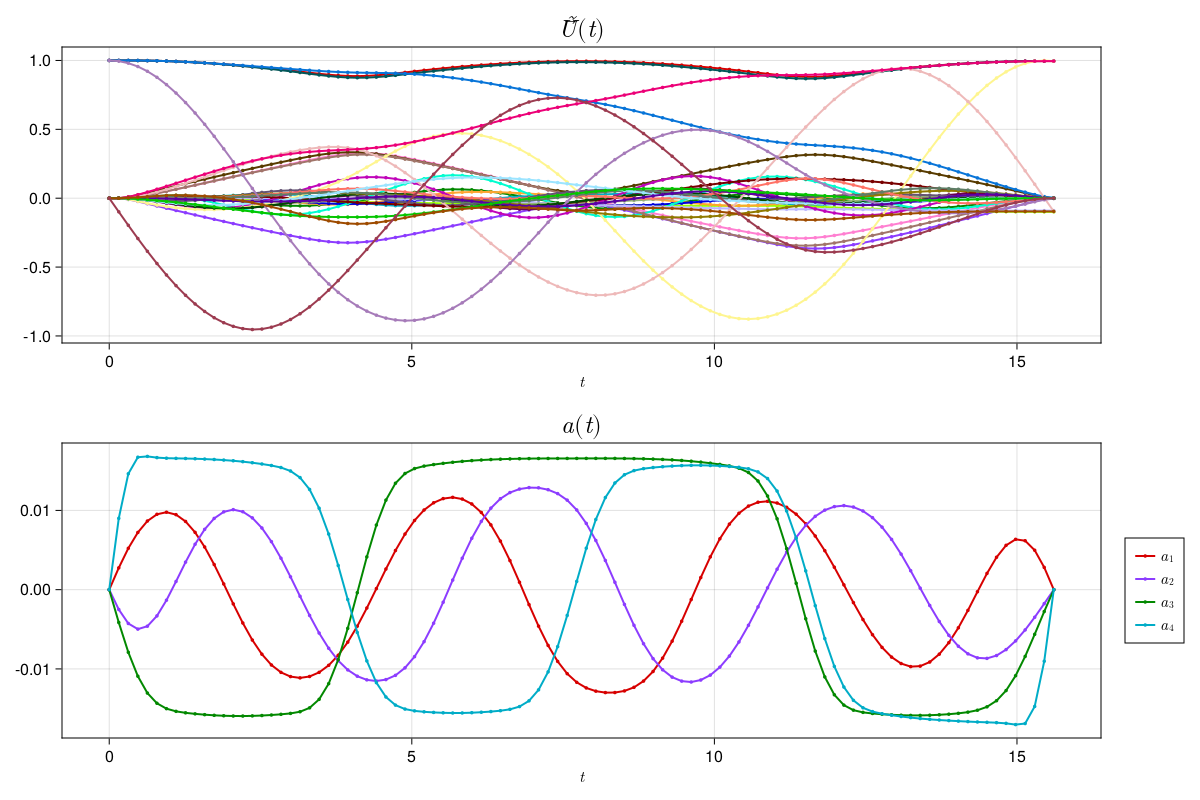

In [49]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

## Minimum Time CNOT

Now let's see how fast we can make this pulse, by setting up and solving a minimum time problem, using the solution we just found.

We will add an objective term to the problem that penalizes the total time, as well as constraint on the final state of the form

$$
\mathcal{F}(U(T)) \geq \mathcal{F}_{\text{target}}.
$$

This enforce that the final fidelity does not decrease below the threshold $\mathcal{F}_{\text{target}}$, while also allowing the phase to shift.

In [50]:
# final fidelity constraint
min_fidelity = 0.9999

# minimum time objective weight
D = 1000.0

# define the problem
mintime_prob = UnitaryMinimumTimeProblem(prob; D=D, final_fidelity=min_fidelity);

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


In [51]:
# solving the problem
QuantumCollocation.solve!(mintime_prob; max_iter=max_iter)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:    34332

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5765954e+02 2.75e-07 5.11e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  1.4882157e+02 1.18e-02 5.02e+00  -1.7 1.01e+00    -  8.61e-01 8.30e-01f  1


   2  1.4214974e+02 4.66e-03 1.87e+00  -1.7 6.45e-01    -  1.00e+00 1.00e+00h  1


   3  1.4798554e+02 2.15e-03 5.77e+00  -1.7 4.05e-01    -  1.00e+00 6.75e-01h  1


   4  1.5311919e+02 1.47e-03 5.90e+00  -1.7 2.18e-01    -  1.00e+00 1.00e+00h  1


   5  1.5166550e+02 7.20e-04 5.29e+01  -1.7 1.34e-01    -  8.29e-01 4.78e-01h  1


   6  1.5320554e+02 7.48e-04 1.06e+01  -1.7 8.00e-02    -  1.00e+00 1.00e+00h  1


   7  1.5259757e+02 5.85e-04 3.96e+02  -1.7 1.05e-01  -2.0 1.00e+00 2.61e-01h  2


   8  1.5260713e+02 5.86e-04 3.50e+02  -1.7 7.91e+00  -1.6 2.35e-02 7.52e-04h  6


   9  1.5275519e+02 5.46e-04 4.07e+02  -1.7 2.17e-01  -1.1 7.11e-01 1.71e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5413606e+02 1.82e-04 3.03e+01  -1.7 5.45e-02  -0.7 1.00e+00 1.00e+00H  1


  11  1.5571342e+02 8.55e-05 2.06e+01  -1.7 3.67e-02  -0.3 1.00e+00 1.00e+00h  1


  12  1.5600596e+02 1.06e-04 5.44e+00  -1.7 2.94e-02  -0.8 1.00e+00 1.00e+00h  1


  13  1.5616073e+02 1.05e-04 9.19e+01  -1.7 1.08e-01  -1.3 1.00e+00 1.25e-01h  4


  14  1.5688679e+02 1.71e-05 4.21e+00  -1.7 1.52e-02  -0.8 1.00e+00 1.00e+00h  1


  15  1.5704281e+02 4.70e-06 2.71e-01  -1.7 6.68e-03  -1.3 1.00e+00 1.00e+00h  1


  16  1.5704294e+02 4.70e-06 3.83e+01  -1.7 1.64e-01    -  8.22e-01 3.09e-03h  9


  17  1.5708414e+02 6.06e-08 3.85e-02  -1.7 1.03e-03  -0.9 1.00e+00 1.00e+00h  1


  18  1.5518210e+02 9.28e-05 8.21e+01  -2.5 3.19e-02  -1.4 9.21e-01 1.00e+00f  1


  19  1.5359525e+02 6.28e-04 2.62e+02  -2.5 9.30e-02  -0.9 3.09e-01 2.23e-01H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5336866e+02 5.70e-05 5.91e+00  -2.5 4.11e-02   0.4 1.00e+00 1.00e+00f  1


  21  1.5265412e+02 2.98e-05 2.52e+00  -2.5 1.51e-02  -0.1 1.00e+00 1.00e+00h  1


  22  1.5197562e+02 4.31e-04 3.45e+01  -2.5 1.72e+00    -  1.07e-01 4.17e-02f  2


  23  1.4982408e+02 2.31e-04 2.83e+01  -2.5 1.20e-01    -  1.00e+00 7.63e-01h  1


  24  1.4992979e+02 7.73e-05 5.00e+00  -2.5 3.19e-02    -  1.00e+00 1.00e+00f  1


  25  1.4995479e+02 8.92e-05 7.68e+01  -2.5 8.94e-02    -  1.00e+00 2.50e-01h  3


  26  1.4999120e+02 8.71e-05 8.24e+01  -2.5 6.72e-02    -  1.00e+00 2.50e-01h  3


  27  1.4997438e+02 5.42e-07 1.43e-01  -2.5 5.19e-03  -0.6 1.00e+00 1.00e+00h  1


  28  1.4997740e+02 1.37e-06 1.88e+01  -2.5 9.34e-03    -  1.00e+00 1.25e-01h  4


  29  1.4997446e+02 2.06e-05 3.70e-02  -2.5 8.96e-03    -  1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4997625e+02 1.96e-05 1.42e+01  -2.5 4.83e-03    -  1.00e+00 6.25e-02h  5


  31  1.5000156e+02 1.44e-07 2.00e-02  -2.5 1.32e-03  -1.0 1.00e+00 1.00e+00h  1


  32  1.4878113e+02 9.40e-05 1.63e+01  -3.8 7.11e-02    -  5.56e-01 5.02e-01f  1


  33  1.4851974e+02 3.17e-04 5.50e+00  -3.8 8.52e+01    -  1.22e-03 1.74e-03f  1


  34  1.4809442e+02 3.45e-04 6.73e+01  -3.8 7.73e-01    -  1.52e-01 6.91e-02h  1


  35  1.4752431e+02 4.52e-04 7.06e+01  -3.8 8.87e+00    -  1.82e-02 1.71e-02f  1


  36  1.4707215e+02 3.95e-04 5.59e+01  -3.8 2.58e-01  -1.5 2.95e-01 1.74e-01h  1


  37  1.4583498e+02 3.37e-04 4.92e+01  -3.8 1.10e-01  -1.1 5.22e-01 9.32e-01f  1


  38  1.4567683e+02 3.34e-04 6.40e+01  -3.8 3.09e+00    -  5.77e-02 2.10e-02h  1


  39  1.4537512e+02 2.25e-04 5.96e+01  -3.8 1.24e-01  -1.6 2.92e-01 3.92e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4498309e+02 3.01e-04 6.71e+01  -3.8 3.90e-01  -2.0 1.42e-01 3.81e-01f  1


  41  1.4477009e+02 2.16e-04 1.31e+01  -3.8 2.68e-01  -1.6 5.68e-01 3.45e-01h  1


  42  1.4469650e+02 1.90e-04 2.34e+01  -3.8 2.73e-01  -2.1 5.19e-01 1.31e-01h  1


  43  1.4456994e+02 1.38e-04 1.60e+01  -3.8 1.93e-01  -2.6 3.84e-01 3.59e-01h  1


  44  1.4456051e+02 1.11e-04 2.33e+01  -3.8 2.93e-01    -  4.10e-01 1.48e-01H  1


  45  1.4457823e+02 1.34e-04 3.12e+01  -3.8 8.25e-01    -  1.57e-01 9.74e-02H  1


  46  1.4447295e+02 1.63e-04 1.91e+01  -3.8 1.89e-01    -  3.01e-01 4.63e-01f  1


  47  1.4447237e+02 1.64e-04 1.12e+01  -3.8 2.63e-01    -  4.59e-01 4.36e-01h  1


  48  1.4445886e+02 4.40e-05 8.27e+00  -3.8 7.90e-02    -  5.90e-01 1.00e+00f  1


  49  1.4440637e+02 1.46e-05 2.69e+01  -3.8 1.77e-01  -2.1 5.12e-01 8.97e-01H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4441169e+02 1.55e-05 9.73e+00  -3.8 6.78e-02  -1.7 7.00e-01 1.00e+00f  1


  51  1.4439951e+02 1.47e-05 6.05e+00  -3.8 2.63e-01    -  6.87e-01 2.02e-01h  1


  52  1.4439791e+02 2.46e-06 5.26e-03  -3.8 6.00e-02    -  1.00e+00 1.00e+00f  1


  53  1.4439956e+02 1.24e-07 2.08e-04  -3.8 1.45e-02  -2.2 1.00e+00 1.00e+00h  1


  54  1.4421013e+02 1.03e-05 1.38e-02  -4.0 4.95e-02    -  1.00e+00 1.00e+00f  1


  55  1.4420956e+02 5.95e-08 2.48e-04  -4.0 1.05e-02    -  1.00e+00 1.00e+00h  1


  56  1.4420954e+02 4.37e-10 6.97e-07  -4.0 4.16e-04    -  1.00e+00 1.00e+00h  1


  57  1.4420954e+02 6.44e-14 3.99e-09  -4.0 3.70e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   1.4420953699665146e+01    1.4420953699665145e+02
Dual infeasibility......:   3.9874016640600862e-09    3.9874016640600862e-08
Constraint violation....:   6.4392935428259079e-14    6.4392935428259079e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000001524185e-04    1.0000000001524185e-03
Overall NLP error.......:   3.9874016640600862e-09    3.9874016640600862e-08


Number of objective function evaluations             = 115
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 115
Number of inequality constraint evaluations          = 115
Number of equality constraint Jacobian evaluations   = 58
Number of inequality constraint Jacobian evaluations = 58
Nu

In [52]:
mintime_final_fidelity = unitary_fidelity(mintime_prob.trajectory, system)
println("Fidelity: $mintime_final_fidelity")

Fidelity: 0.9999000995790256


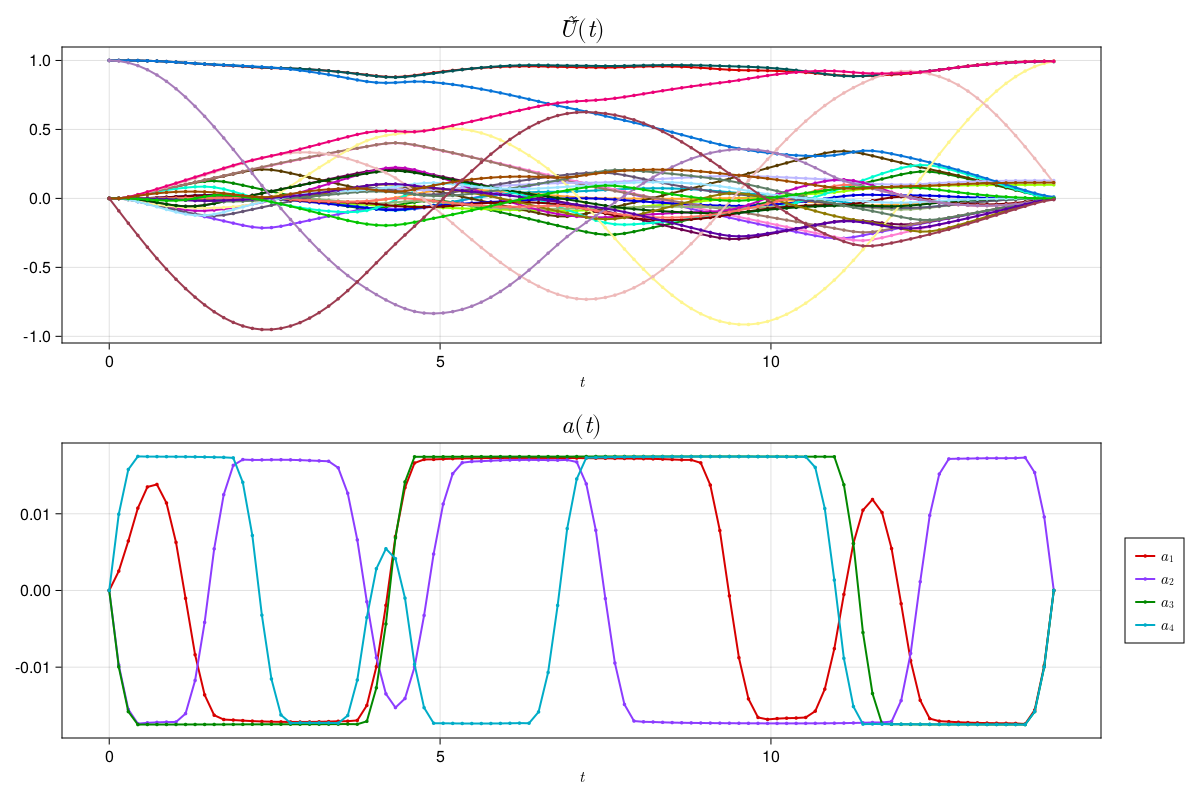

In [53]:
plot(mintime_prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

In [54]:
original_duration = times(prob.trajectory)[end]
mintime_duration = times(mintime_prob.trajectory)[end]
println("Original Duration: $original_duration ns")
println("Minimum Duration:  $mintime_duration ns")

Original Duration: 15.608079626734712 ns
Minimum Duration:  14.274237182155819 ns


## Model Mismatch and Iterative Learning Control

Now let's imagine that our goal is to test this pulse on an experimental system where we anticipate some hamiltonian errors. First we will define some states on this system using the `cavity_state` function to create states $\ket{g}$, $\ket{e}$ for individual qubits, and $\ket{gg}$, $\ket{ge}$, $\ket{eg}$, and $\ket{ee}$ on the combined two qubit system.

In [55]:
experimental_levels = 2

# define quantum ground state |g⟩
g = cavity_state(0, experimental_levels)

# define quantum excited state |e⟩
e = cavity_state(1, experimental_levels)

# define quantum states |gg⟩, |ge⟩, |eg⟩, |ee⟩
gg = g ⊗ g
ge = g ⊗ e
eg = e ⊗ g
ee = e ⊗ e;

Here we set up the experiments for the system using the `QuantumSimulationExperiment` constructor.

In [56]:
# unitary fidelity measurement function
unitary_fidelity_measurement = Ũ⃗ -> begin
    U_experiment = iso_vec_to_operator(Ũ⃗)
    return [unitary_fidelity(U_experiment, U_goal)]
end

experimental_initial_states = [
    gg,
    ge,
    eg,
    ee
]

measurement = Ũ⃗ -> begin
    U_experiment = iso_vec_to_operator(Ũ⃗)
    return [fidelity(U_experiment * ψ, U_goal * ψ) for ψ ∈ experimental_initial_states]
end


#19 (generic function with 1 method)

We will assume model mismatch of the form

$$
H_{\text{error}} = \epsilon_X (X \otimes I + I \otimes X) + \epsilon_Y (Y \otimes I + I \otimes Y) + \epsilon_Z (Z \otimes I + I \otimes Z)
$$

In [57]:

X_error = 0.002 
Y_error = -0.007
Z_error = 0.006 

H_error = -1.0im * (
    X_error * (GATES[:X] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:X]) +
    Y_error * (GATES[:Y] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:Y]) +
    Z_error * (GATES[:Z] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:Z])
) 

G_error = iso(H_error);

In [58]:



# define the measurement times
τs = [prob.trajectory.T]

# define initial unitary
U_init = I(4) 

# define the simulation experiment
experiment = QuantumSimulationExperiment(
    system,
    operator_to_iso_vec(U_init),
    measurement,
    τs;
    unitary=true,
    G_error_term=G_error
);

# define the simulation experiment
unitary_fidelity_experiment = QuantumSimulationExperiment(
    system,
    operator_to_iso_vec(U_init),
    unitary_fidelity_measurement,
    τs;
    unitary=true,
    G_error_term=G_error
);



Here we define the reference trajectory and measure the unitary fidelity on the target system

In [59]:
# select goal trajectory
# -------------------------------------
# goal_prob = prob
goal_prob = mintime_prob

# calculate experimental fidelity
experiment_fidelity = unitary_fidelity_experiment(
    goal_prob.trajectory.a, 
    goal_prob.trajectory.Δt
).ys[end][end]

println("experimental fidelity = ", experiment_fidelity)

experimental fidelity = 0.9898719654595916


Here we define and solve the ILC problem using the `ILCProblem` constructor and `solve!` method.

In [60]:
# backtrackign line search intial step size
α = 0.5^1

ILC_max_iter = 5 


Qf = 300.0

ILC_prob = ILCProblem(goal_prob, experiment; 
    α=α, 
    max_iter=ILC_max_iter,
    Qf=Qf,
)

solve!(ILC_prob);



Setting up dynamic QP...


building constraint matrix for a
building constraint matrix for dda
building constraint matrix for Δt
Building initial and final constraint matrices...
Building initial constraint matrix for Ũ⃗...
Building initial constraint matrix for a...
Building final constraint matrix for a...

Iteration 1


    J(Aⁱ) = 0.04177564887665497



        J = 1.107483936980738, α = 0.5


        J = 0.2867271378303444, α = 0.25


        J = 0.07694682538922415, α = 0.125


        J = 0.03803150833864333, α = 0.0625



Iteration 2


    J(Aⁱ) = 0.03803150833864333



        J = 2.1356461016641557, α = 0.5


        J = 0.6583292142126613, α = 0.25


        J = 0.17372737256004023, α = 0.125


        J = 0.06139030093261311, α = 0.0625


        J = 0.038953898802295384, α = 0.03125


        J = 0.03587344585661456, α = 0.015625



Iteration 3


    J(Aⁱ) = 0.03587344585661456



        J = 2.110542314527403, α = 0.5


        J = 0.69235528801733, α = 0.25


        J = 0.20339054822663083, α = 0.125


        J = 0.07786899418760573, α = 0.0625


        J = 0.04666840740106992, α = 0.03125


        J = 0.038773033412984215, α = 0.015625


        J = 0.03670663585284517, α = 0.0078125


        J = 0.03613694708012549, α = 0.00390625


        J = 0.0359670595793139, α = 0.001953125


        J = 0.03591073583474402, α = 0.0009765625


        J = 0.0358897138089358, α = 0.00048828125


        J = 0.035880985847629776, α = 0.000244140625


        α < cutoff



Iteration 4


    J(Aⁱ) = 0.03587344585661456



        J = 2.110542314527403, α = 0.5


        J = 0.69235528801733, α = 0.25


        J = 0.20339054822663083, α = 0.125


        J = 0.07786899418760573, α = 0.0625


        J = 0.04666840740106992, α = 0.03125


        J = 0.038773033412984215, α = 0.015625


        J = 0.03670663585284517, α = 0.0078125


        J = 0.03613694708012549, α = 0.00390625


        J = 0.0359670595793139, α = 0.001953125


        J = 0.03591073583474402, α = 0.0009765625


        J = 0.0358897138089358, α = 0.00048828125


        J = 0.035880985847629776, α = 0.000244140625


        α < cutoff



Iteration 5


    J(Aⁱ) = 0.03587344585661456



        J = 2.1110071669216808, α = 0.5


        J = 0.6986936016795028, α = 0.25


        J = 0.2063187779339859, α = 0.125


        J = 0.07925183929375068, α = 0.0625


        J = 0.04733965899386727, α = 0.03125


        J = 0.039103620264290706, α = 0.015625


        J = 0.0368706661763063, α = 0.0078125


        J = 0.03621864575406819, α = 0.00390625


        J = 0.03600782968604321, α = 0.001953125


        J = 0.03593110106576436, α = 0.0009765625


        J = 0.035899891466937395, α = 0.00048828125


        J = 0.035886073437002564, α = 0.000244140625


        α < cutoff


In [61]:
animation_path = "two_qubit.gif"
save_animation(ILC_prob, animation_path; plot_states=false, fps=5);

In [62]:
final_ILC_fidelity = unitary_fidelity_experiment(ILC_prob.Zs[end].a, ILC_prob.Zs[end].Δt).ys[end][end]
initial_ILC_fidelity = unitary_fidelity_experiment(ILC_prob.Zs[1].a, ILC_prob.Zs[1].Δt).ys[end][end]
println("initial ILC fidelity: $initial_ILC_fidelity")
println("final ILC fidelity:   $final_ILC_fidelity")

initial ILC fidelity: 0.9898719654595916
final ILC fidelity:   0.9931945285136257


In [63]:
final_ILC_infidelity = 1.0 - final_ILC_fidelity
initial_ILC_infidelity = 1.0 - initial_ILC_fidelity
println("initial ILC infidelity: $initial_ILC_infidelity")
println("final ILC infidelity:   $final_ILC_infidelity")

initial ILC infidelity: 0.010128034540408448
final ILC infidelity:   0.006805471486374337


In [64]:
improvement_percentage = round((final_ILC_infidelity - initial_ILC_infidelity) / initial_ILC_infidelity * 100, digits=2)
println("ILC relative infidelity decrease: ", abs(improvement_percentage), "%")

ILC relative infidelity decrease: 32.81%
